In [1]:
import random
import numpy as np
random.seed(42)
np.random.seed(42)


# Create Synthitic Data

In [2]:
!pip install faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.2 MB/s eta 0:00:00


In [3]:
# Import necessary libraries
import pandas as pd
import random
from faker import Faker
import numpy as np

In [4]:
# Create a Faker object for generating fake data
fake = Faker()

# Vendor names
vendors = ['Vendor A', 'Vendor B', 'Vendor C']

# Initialize an empty list to hold the synthetic data
data = []

In [5]:
#creat the data
for _ in range(5000):
    vendor = random.choice(vendors)
    otp_sent = random.randint(0, 1)
    response_time = np.random.randint(1000, 15000)
    error_rate = np.random.uniform(0.01, 0.2)  # معدل أخطاء عشوائي
    data.append({
        'Vendor Name': vendor,
        'Vendor ID': fake.uuid4(),
        'OTP Sent': otp_sent,
        'Response Time (ms)': response_time,
        'Error Rate': error_rate,
        'Date': fake.date_this_year()
    })

df = pd.DataFrame(data)



# Feature Engineering

In [6]:
# إضافة الأعمدة الجديدة
df['Country Code'] = '+966'
df['Phone Number'] = ['050' + ''.join([str(random.randint(0, 9)) for _ in range(7)]) for _ in range(len(df))]
df['Day'] = pd.to_datetime(df['Date']).dt.day_name()
df['Response Time (s)'] = df['Response Time (ms)'] / 1000


In [7]:
# حساب معدل النجاح لكل مزود
def calculate_success_rate(row):
    base_rate = 0.8 if row['OTP Sent'] == 1 else 0.2
    adjusted_rate = base_rate * (1 - (row['Error Rate'] / 2))
    return adjusted_rate
#The Error Rate is divided by 2 and then subtracted from 1. This value is then multiplied by the base_rate to get the adjusted_rate.
#This adjustment essentially reduces the success rate proportionally to the vendor's error rate. A higher error rate leads to a lower adjusted success rate.
df['Success Rate'] = df.apply(calculate_success_rate, axis=1)

In [8]:
vendor_base_rates = {'Vendor A': 0.85, 'Vendor B': 0.75, 'Vendor C': 0.65}
#each vendor starts with a different initial success rate assumption, which is then adjusted based on their error rate.
#base_rate is determined by the vendor's name and is retrieved from the vendor_base_rates dictionary. This allows for different initial success rate assumptions for different vendors.
def calculate_success_rate(row):
    base_rate = vendor_base_rates[row['Vendor Name']]
    adjusted_rate = base_rate * (1 - (row['Error Rate'] / 2))
    return adjusted_rate


In [9]:
def peak_hours_classification(row):
    hour = fake.time_object().hour
    #return "Peak" if 9 <= hour <= 18 else "Off-Peak": Returns "Peak" if the random hour falls between 9 AM and 6 PM (inclusive), and "Off-Peak" otherwise.
    return "Peak" if 9 <= hour <= 18 else "Off-Peak"

df['Time Period'] = df.apply(peak_hours_classification, axis=1)


In [10]:
# تصنيف الأداء بناءً على معدل النجاح
def classify_vendor_performance(success_rate):
    if success_rate > 0.85:
        return 'High'
    elif success_rate > 0.6:
        return 'Medium'
    else:
        return 'Low'
df['Vendor Performance'] = df['Success Rate'].apply(classify_vendor_performance)


In [11]:
# Updated phone number generation with diverse prefixes
operator_prefixes = {
    'STC': ['050', '053', '055'],
    'Mobily': ['054', '056'],
    'Virgin': ['057'],
    'Zain': ['058', '059']
}

def generate_phone_number_and_operator():
    operator = random.choice(list(operator_prefixes.keys()))
    prefix = random.choice(operator_prefixes[operator])
    number = ''.join([str(random.randint(0, 9)) for _ in range(7)])
    return f"{prefix}{number}", operator

# Generate phone numbers and operators
df['Phone Number'], df['Operator'] = zip(*[generate_phone_number_and_operator() for _ in range(len(df))])

# Check the updated DataFrame
print(df[['Phone Number', 'Operator']].head())


  Phone Number Operator
0   0568947706   Mobily
1   0548532025   Mobily
2   0571679467   Virgin
3   0588986361     Zain
4   0569459211   Mobily


# **Data analysis**


In [12]:
# تحليل البيانات
print(df.head())
print("Summary Statistics:")
print(df.describe())

  Vendor Name                             Vendor ID  OTP Sent  \
0    Vendor C  cb73912c-7e1d-4eac-9ee0-6ac9d238c67c         0   
1    Vendor A  dfa2001e-d615-4771-bac7-063d704fc92c         1   
2    Vendor A  e729e040-f37c-4ffe-ad73-ececa3cb1b09         0   
3    Vendor A  a7a273eb-b427-44f7-a3a8-8bf93b55c111         0   
4    Vendor C  0c8492c0-e8fb-4ab1-9830-4fed0805f090         0   

   Response Time (ms)  Error Rate        Date Country Code Phone Number  \
0                8270    0.161343  2025-01-24         +966   0568947706   
1                6390    0.149079  2025-01-24         +966   0548532025   
2               12964    0.123402  2025-01-28         +966   0571679467   
3                7265    0.039639  2025-01-26         +966   0588986361   
4                5426    0.097257  2025-01-27         +966   0569459211   

       Day  Response Time (s)  Success Rate Time Period Vendor Performance  \
0   Friday              8.270      0.183866        Peak                Low   
1 

In [13]:
# حساب إحصائيات الأداء
vendor_summary = df.groupby('Vendor Name').agg({
    'Success Rate': ['mean', 'std'],
    'Response Time (s)': ['mean', 'std']
})
print("Vendor Summary Statistics:")
print(vendor_summary)

Vendor Summary Statistics:
            Success Rate           Response Time (s)          
                    mean       std              mean       std
Vendor Name                                                   
Vendor A        0.468899  0.284691          7.978715  4.080200
Vendor B        0.477823  0.285074          7.957853  4.067442
Vendor C        0.474220  0.284889          8.109045  4.025872


In [14]:
print(df.head())

  Vendor Name                             Vendor ID  OTP Sent  \
0    Vendor C  cb73912c-7e1d-4eac-9ee0-6ac9d238c67c         0   
1    Vendor A  dfa2001e-d615-4771-bac7-063d704fc92c         1   
2    Vendor A  e729e040-f37c-4ffe-ad73-ececa3cb1b09         0   
3    Vendor A  a7a273eb-b427-44f7-a3a8-8bf93b55c111         0   
4    Vendor C  0c8492c0-e8fb-4ab1-9830-4fed0805f090         0   

   Response Time (ms)  Error Rate        Date Country Code Phone Number  \
0                8270    0.161343  2025-01-24         +966   0568947706   
1                6390    0.149079  2025-01-24         +966   0548532025   
2               12964    0.123402  2025-01-28         +966   0571679467   
3                7265    0.039639  2025-01-26         +966   0588986361   
4                5426    0.097257  2025-01-27         +966   0569459211   

       Day  Response Time (s)  Success Rate Time Period Vendor Performance  \
0   Friday              8.270      0.183866        Peak                Low   
1 

# **modifications:**

In [15]:
# عمود يوضح إذا تم الانتقال إلى مزود بديل في حالة فشل المزود الرئيسي
def determine_failover(row):
    if row['OTP Sent'] == 0:  # Failed delivery
        return 'Switch to Backup Vendor'
    else:
        return 'Delivered'
df['Failover Mechanism'] = df.apply(determine_failover, axis=1)


In [16]:
#تحسين احتمالية فشل المزود الرئيسي
df['Primary Vendor Failure Rate'] = df['Error Rate'] * 1.2


In [17]:
df['Delay Time (s)'] = df['Response Time (s)'] * random.uniform(1.1, 1.5)# Additional delay added to the response time to simulating real-world network conditions


In [18]:
#نسبة نجاح المزود الاحتياطي
df['Backup Vendor Success Rate'] = random.uniform(0.7, 0.95)


In [19]:
# توزيع مخصص لزيادة الفشل في أوقات الذروة
#uses df.loc to select specific rows and columns in the DataFrame df
df.loc[df['Time Period'] == 'Peak', 'Primary Vendor Failure Rate'] *= 1.3
#For these peak-hour rows, it increases the 'Primary Vendor Failure Rate' by 30% (multiplying by 1.3). This simulates the increased likelihood of failures during peak times, making your data or simulation more realistic.


In [20]:
# Add Retry Attempts
df['Retry Attempts'] = np.random.randint(0, 3, size=len(df))

# Simulate Customer Device Types
device_types = ['Mobile', 'Desktop', 'Tablet']
df['Device Type'] = np.random.choice(device_types, size=len(df))

# Simulate Geographic Locations
locations = ['Urban', 'Rural', 'Suburban']
df['Location'] = np.random.choice(locations, size=len(df))

# Simulate Network Conditions
df['Network Latency (ms)'] = np.random.randint(50, 500, size=len(df))

# Feature Engineering: Peak Hours
def adjust_for_peak_hours(row):
    if row['Time Period'] == 'Peak':
        return row['Response Time (s)'] * np.random.uniform(1.2, 1.5)
    else:
        return row['Response Time (s)'] * np.random.uniform(0.8, 1.0)
df['Adjusted Response Time'] = df.apply(adjust_for_peak_hours, axis=1)

# **Model**

In [21]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder


In [22]:
# Model Training with Additional Features
label_encoder = LabelEncoder()
features = ['Adjusted Response Time', 'Error Rate', 'Primary Vendor Failure Rate',
            'Backup Vendor Success Rate', 'Retry Attempts', 'Network Latency (ms)',
            'Time Period']
target = 'Failover Mechanism'
df['Time Period'] = label_encoder.fit_transform(df['Time Period'])

X = df[features]
y = label_encoder.fit_transform(df[target])

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# **improvment**


In [24]:
df['Adjusted Success Rate'] = df['Success Rate'] * (1 - df['Primary Vendor Failure Rate'])
df['Adjusted Response Time'] = df['Response Time (s)'] * df['Error Rate']
df['Vendor Priority'] = df['Vendor Name'].map({'Vendor A': 1, 'Vendor B': 2, 'Vendor C': 3})


In [25]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [26]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(random_state=42, n_estimators=100)
lgb_model.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1985, number of negative: 2015
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1014
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496250 -> initscore=-0.015000
[LightGBM] [Info] Start training from score -0.015000


LGBMClassifier(random_state=42)

In [27]:
from sklearn.model_selection import cross_val_score, GridSearchCV

param_grid = {
    'num_leaves': [31, 50, 70],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 500]
}
grid_search = GridSearchCV(lgb.LGBMClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)

best_model = grid_search.best_estimator_

# Evaluate performance using cross-validation scores
scores = cross_val_score(best_model, X, y, cv=5)
#here i use  GridSearchCV with cross-validation and a comprehensive hyperparameter grid bc it helps mitigate overfitting concerns
print("Best Model:", best_model)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2501, number of negative: 2501
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1017
[LightGBM] [Info] Number of data points in the train set: 5002, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2000, number of negative: 2000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1017
[

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = best_model.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[475   9]
 [  5 511]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       484
           1       0.98      0.99      0.99       516

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



In [36]:
print(df.head())

  Vendor Name                             Vendor ID  OTP Sent  \
0    Vendor C  cb73912c-7e1d-4eac-9ee0-6ac9d238c67c         0   
1    Vendor A  dfa2001e-d615-4771-bac7-063d704fc92c         1   
2    Vendor A  e729e040-f37c-4ffe-ad73-ececa3cb1b09         0   
3    Vendor A  a7a273eb-b427-44f7-a3a8-8bf93b55c111         0   
4    Vendor C  0c8492c0-e8fb-4ab1-9830-4fed0805f090         0   

   Response Time (ms)  Error Rate        Date Country Code Phone Number  \
0                8270    0.161343  2025-01-24         +966   0568947706   
1                6390    0.149079  2025-01-24         +966   0548532025   
2               12964    0.123402  2025-01-28         +966   0571679467   
3                7265    0.039639  2025-01-26         +966   0588986361   
4                5426    0.097257  2025-01-27         +966   0569459211   

       Day  Response Time (s)  ...  Primary Vendor Failure Rate  \
0   Friday              8.270  ...                     0.251695   
1   Friday              

# **Logistic Regression Model**

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split # Import train_test_split



# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the resampled data into training and testing sets
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

# Initialize and train the Logistic Regression model
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X_train_resampled, y_train_resampled)  # Use the resampled training data

# Make predictions using the resampled test data
y_pred_logreg = logreg_model.predict(X_test_resampled)

# Evaluate the model
print("Logistic Regression Confusion Matrix:\n", confusion_matrix(y_test_resampled, y_pred_logreg))
print("\nLogistic Regression Classification Report:\n", classification_report(y_test_resampled, y_pred_logreg))

Logistic Regression Confusion Matrix:
 [[289 197]
 [304 211]]

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.59      0.54       486
           1       0.52      0.41      0.46       515

    accuracy                           0.50      1001
   macro avg       0.50      0.50      0.50      1001
weighted avg       0.50      0.50      0.50      1001



In [ ]:
#from google.colab import files
#df.to_csv('otp_data.csv', index=False)
#files.download('otp_data.csv')

# **Test**

In [37]:
# Required features from the model
required_features = ['Adjusted Response Time', 'Error Rate', 'Primary Vendor Failure Rate',
            'Backup Vendor Success Rate', 'Retry Attempts', 'Network Latency (ms)',
            'Time Period']

# Create a sample DataFrame with some data
# Example data:
new_data = [[1.5, 0.05, 0.06, 0.8, 0, 1.65, 2]]
new_data_df = pd.DataFrame(new_data, columns=required_features)

# new_data_df contains only the required features
new_data_df = new_data_df[required_features]

# Predict with the trained model
predictions = best_model.predict(new_data_df)

# Add predictions to the DataFrame
new_data_df['Predicted Failover'] = predictions

# Display predictions
print("Sample Predictions:")
print(new_data_df.head())

Sample Predictions:
   Adjusted Response Time  Error Rate  Primary Vendor Failure Rate  \
0                     1.5        0.05                         0.06   

   Backup Vendor Success Rate  Retry Attempts  Network Latency (ms)  \
0                         0.8               0                  1.65   

   Time Period  Predicted Failover  
0            2                   0  


In [43]:
import pandas as pd

# Sample test cases with different feature values
test_data = pd.DataFrame([
    # Case 1: High response time, high error rate, peak hours
    {"Adjusted Response Time": 15.0, "Error Rate": 0.3, "Primary Vendor Failure Rate": 0.4,
     "Backup Vendor Success Rate": 0.9, "Retry Attempts": 2, "Network Latency (ms)": 300, "Time Period": 1},

    # Case 2: Moderate response time, low error rate, off-peak hours
    {"Adjusted Response Time": 5.0, "Error Rate": 0.1, "Primary Vendor Failure Rate": 0.15,
     "Backup Vendor Success Rate": 0.8, "Retry Attempts": 1, "Network Latency (ms)": 100, "Time Period": 0},

    # Case 3: Low response time, very low error rate, peak hours
    {"Adjusted Response Time": 2.0, "Error Rate": 0.02, "Primary Vendor Failure Rate": 0.05,
     "Backup Vendor Success Rate": 0.95, "Retry Attempts": 0, "Network Latency (ms)": 50, "Time Period": 1},

    # Case 4: High response time, moderate error rate, many retry attempts, off-peak hours
    {"Adjusted Response Time": 12.0, "Error Rate": 0.2, "Primary Vendor Failure Rate": 0.3,
     "Backup Vendor Success Rate": 0.7, "Retry Attempts": 3, "Network Latency (ms)": 200, "Time Period": 0},

    # Case 5: Very high primary vendor failure rate, peak hours
    {"Adjusted Response Time": 8.0, "Error Rate": 0.25, "Primary Vendor Failure Rate": 0.8,
     "Backup Vendor Success Rate": 0.85, "Retry Attempts": 1, "Network Latency (ms)": 150, "Time Period": 1},

])

# Predict with the trained model
predictions = best_model.predict(test_data)

# Add predictions to DataFrame
test_data["Predicted Failover"] = predictions
# 0 indicates a failed OTP delivery (requiring failover), and 1 indicates successful delivery

# Display results
print("Test Predictions:")
print(test_data)

Test Predictions:
   Adjusted Response Time  Error Rate  Primary Vendor Failure Rate  \
0                    15.0        0.30                         0.40   
1                     5.0        0.10                         0.15   
2                     2.0        0.02                         0.05   
3                    12.0        0.20                         0.30   
4                     8.0        0.25                         0.80   

   Backup Vendor Success Rate  Retry Attempts  Network Latency (ms)  \
0                        0.90               2                   300   
1                        0.80               1                   100   
2                        0.95               0                    50   
3                        0.70               3                   200   
4                        0.85               1                   150   

   Time Period  Predicted Failover  
0            1                   0  
1            0                   1  
2            1         

# vis

In [39]:
import matplotlib.pyplot as plt

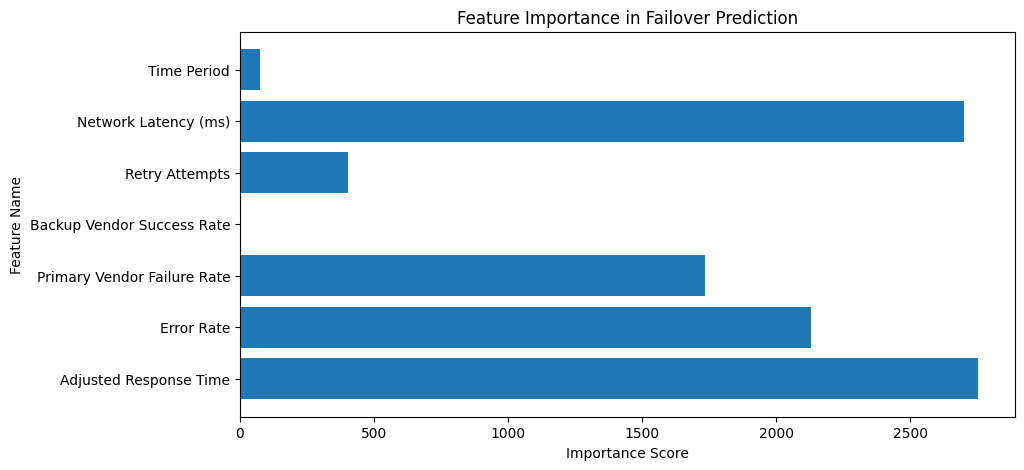

Confusion Matrix:
[[475   9]
 [  5 511]]
False Positive Rate: 1.86%
False Negative Rate: 0.97%


In [44]:

# Check Feature Importance
importances = best_model.feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(10, 5))
plt.barh(feature_names, importances)
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.title("Feature Importance in Failover Prediction")
plt.show()

# Check Model Performance
from sklearn.metrics import confusion_matrix

y_test_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)

print("Confusion Matrix:")
print(cm)

false_positive_rate = cm[0][1] / sum(cm[0])
false_negative_rate = cm[1][0] / sum(cm[1])

print(f"False Positive Rate: {false_positive_rate:.2%}")
print(f"False Negative Rate: {false_negative_rate:.2%}")


# **Save model**

In [46]:
import joblib

# Define the model filename
model_filename = "otp_failover_best_model.pkl"

#Save the trained model
joblib.dump(best_model, model_filename)

print(f"Model saved as {model_filename}")
#Save the trained model
joblib.dump(best_model, model_filename)

print(f"Model saved as {model_filename}")


Model saved as otp_failover_best_model.pkl
Model saved as otp_failover_best_model.pkl


In [47]:
from google.colab import files

#Download the model file
files.download(model_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# save dataset

In [ ]:
#from google.colab import files
#df.to_csv('otp_data.csv', index=False)
#files.download('otp_data.csv')

# **to put it in github**

In [48]:
pip freeze > requirements.txt

In [50]:
!apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


In [53]:
!git config --global user.email'shouqalsufayan9@gmail.com'
!git config --global user.name'Shouq2003'

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [55]:
!git remote add origin https://github.com/Shouq2003/OTP_Faiover_project.git

fatal: not a git repository (or any of the parent directories): .git
